## Work
請自行定義一個 Loss Function，為 $w * Focal\ Loss + (1-w) * CrossEntropy\ Loss$，訓練並比較結果


In [1]:
!nvidia-smi

Sat Mar 12 17:57:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
from tensorflow import keras

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preproc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896 

In [7]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [8]:
import tensorflow as tf

def combined_loss(w, gamma=2., alpha=4.):
    w = float(w)
    gamma = float(gamma)
    alpha = float(alpha)
    
    def ce_focal_loss(y_true, y_pred):
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        
        f_loss = tf.reduce_mean(reduced_fl)
        
        ce_loss = keras.losses.categorical_crossentropy(y_true, y_pred)

        return w * ce_loss + (1. - w) * f_loss
    
    return ce_focal_loss

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [9]:
results = {}

for i, ce_w in enumerate(ce_weights_list):
    keras.backend.clear_session()
    
    print(f"Exp: {i+1}, ce_weight: {ce_w:.2f}")

    model = build_mlp(input_shape=x_train.shape[1:])
    
    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    
    model.compile(loss=combined_loss(ce_w), metrics=["accuracy"], optimizer=optimizer)

    history = model.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE, 
                        validation_data=(x_test, y_test), 
                        shuffle=True, 
                        verbose=0)
    
    # Collect results
    exp_name_tag = (f"ce_weight: {ce_w:.2f}")
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Exp: 1, ce_weight: 0.00
Exp: 2, ce_weight: 0.30
Exp: 3, ce_weight: 0.50
Exp: 4, ce_weight: 0.70
Exp: 5, ce_weight: 1.00


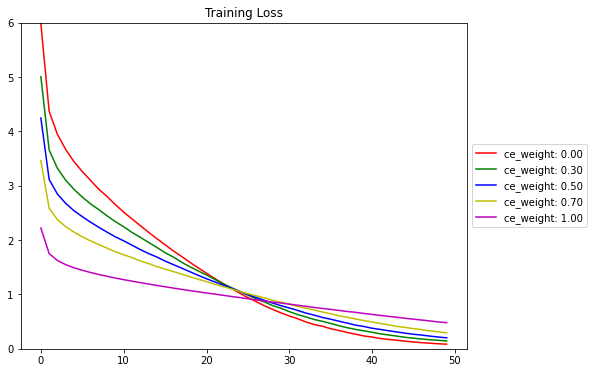

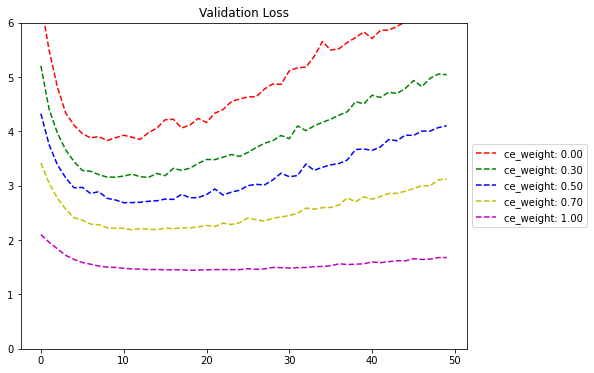

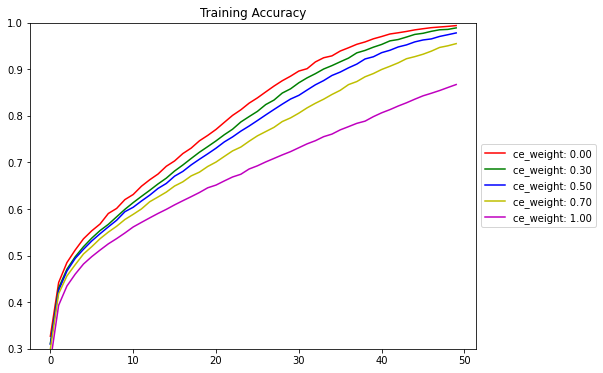

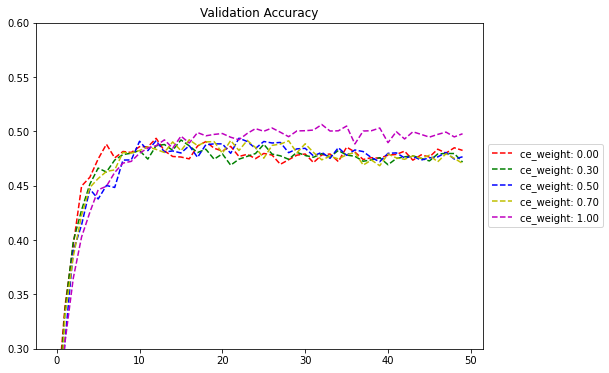

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])), results[cond]['train-loss'], 
             '-', label=cond, color=color_bar[i])
plt.title("Training Loss")
plt.ylim([0, 6])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid-loss'])), results[cond]['valid-loss'], 
             '--', label=cond, color=color_bar[i])
plt.title("Validation Loss")
plt.ylim([0, 6])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])), results[cond]['train-acc'], 
             '-', label=cond, color=color_bar[i])
plt.title("Training Accuracy")
plt.ylim([0.3, 1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], 
             '--', label=cond, color=color_bar[i])
plt.title("Validation Accuracy")
plt.ylim([0.3, 0.6])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()